In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os


### Define Functions to Parse Logs

In [2]:
def parse_log_file(filename):
    """
    Parses a log file and returns a DataFrame with the extracted metrics.
    """
    data = []
    with open(filename, 'r') as file:
        for line in file:
            # Remove leading and trailing whitespaces
            line = line.strip()
            # Skip empty lines
            if not line:
                continue
            # Check for 'Epoch' format
            if line.startswith('Epoch:'):
                pattern = r'Epoch: (\d+), time: ([\d\.]+), Train Loss: ([\deE\+\-\.]+),Vali Loss: ([\deE\+\-\.]+), Train l2: ([\d\.]+), Vali l2: ([\d\.]+)'
                match = re.match(pattern, line)
                if match:                    
                    epoch = int(match.group(1))
                    time = float(match.group(2))
                    train_loss = float(match.group(3))
                    val_loss = float(match.group(4))
                    train_l2 = float(match.group(5))
                    val_l2 = float(match.group(6))
                    mse = None
                    data.append([epoch, time, mse, train_l2, val_l2, train_loss, val_loss])
            # Check for numeric lines (other format)
            elif re.match(r'^\d+ \d+.*', line):
                parts = line.split()
                if len(parts) >= 5:
                    epoch = int(parts[0])
                    time = float(parts[1])
                    mse = float(parts[2])
                    train_l2 = float(parts[3])
                    val_l2 = float(parts[4])
                    # Additional metrics if available
                    extra_metrics = list(map(float, parts[5:]))
                    data_row = [epoch, time, mse, train_l2, val_l2] + extra_metrics
                    data.append(data_row)
                elif len(parts) >= 4:
                    epoch = int(parts[0])
                    time = float(parts[1])
                    mse = None
                    train_l2 = float(parts[2])
                    val_l2 = float(parts[3])
                    # Additional metrics if available
                    extra_metrics = list(map(float, parts[4:]))
                    data_row = [epoch, time, mse, train_l2, val_l2] + extra_metrics
                    data.append(data_row)
    # Create DataFrame
    if data:
        columns = ['Epoch', 'Time', 'Train MSE', 'Train l2', 'Validation l2', 'Train Loss', 'Validation Loss']
        df = pd.DataFrame(data, columns=columns[:len(data[0])])
        return df
    else:
        print(f"No data found in {filename}")
        return pd.DataFrame()

###  Load and Parse Log Files

In [3]:
# List of log files to parse
directory = "results/"
log_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
# log_files = ['output_f2d_darcy241.txt', 'output_h2d_darcy241.txt', 'output_s2d_darcy241.txt']  # Replace with your actual filenames
log_files

['r_lno_pendulum_1d_c05.txt',
 'r_fno_pendulum_1d_c05.txt',
 'r_hno_pendulum_1d_c05.txt']

In [4]:

# Dictionary to store DataFrames
logs_data = {}

for file in log_files:
    file = directory + file
    df = parse_log_file(file)
    if not df.empty:
        logs_data[file] = df

In [5]:
logs_data

{'results/r_lno_pendulum_1d_c05.txt':      Epoch   Time Train MSE  Train l2  Validation l2  Train Loss  \
 0        0  0.499      None    4.0189         4.7382    0.244100   
 1        1  0.041      None    3.2896         4.5929    0.195500   
 2        2  0.040      None    2.3530         1.7574    0.148400   
 3        3  0.040      None    1.7813         1.5141    0.111400   
 4        4  0.040      None    1.7033         1.1966    0.105700   
 ..     ...    ...       ...       ...            ...         ...   
 995    995  0.040      None    0.0700         0.1433    0.001357   
 996    996  0.040      None    0.0699         0.1407    0.001354   
 997    997  0.040      None    0.0701         0.1461    0.001353   
 998    998  0.040      None    0.0700         0.1446    0.001355   
 999    999  0.040      None    0.0700         0.1407    0.001356   
 
      Validation Loss  
 0           0.246700  
 1           0.121900  
 2           0.090740  
 3           0.079350  
 4           

### Plotting Functions

In [6]:
def plot_metrics(logs_data, metric='Train Loss'):
    """
    Plots the specified metric for each log file.
    """
    plt.figure(figsize=(10, 6))
    for filename, df in logs_data.items():
        label = filename.split('/')[1].split('.')[0]
        if metric in df.columns:
            plt.plot(df['Epoch'], df[metric], label=label)
        else:
            print(f"Metric '{metric}' not found in {filename}")
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f'{metric} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"plots/epoch_{metric}.png")
    plt.show()

### Plot Metrics

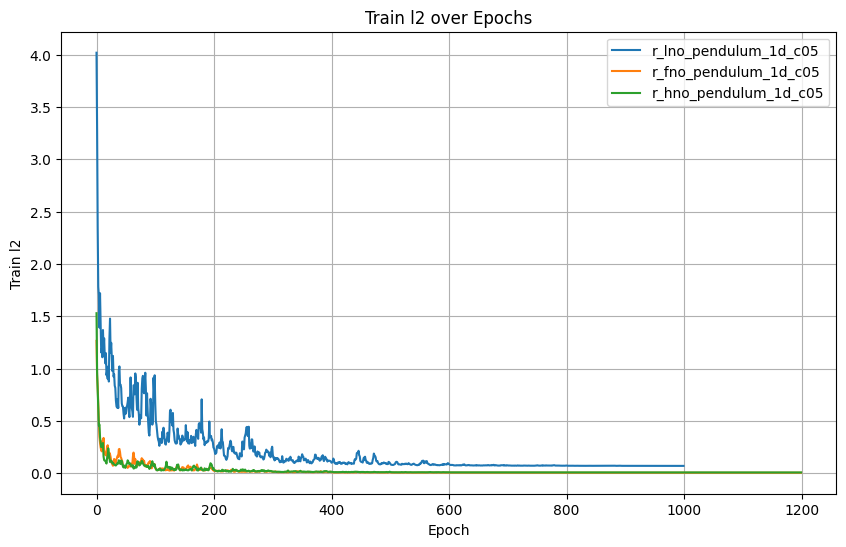

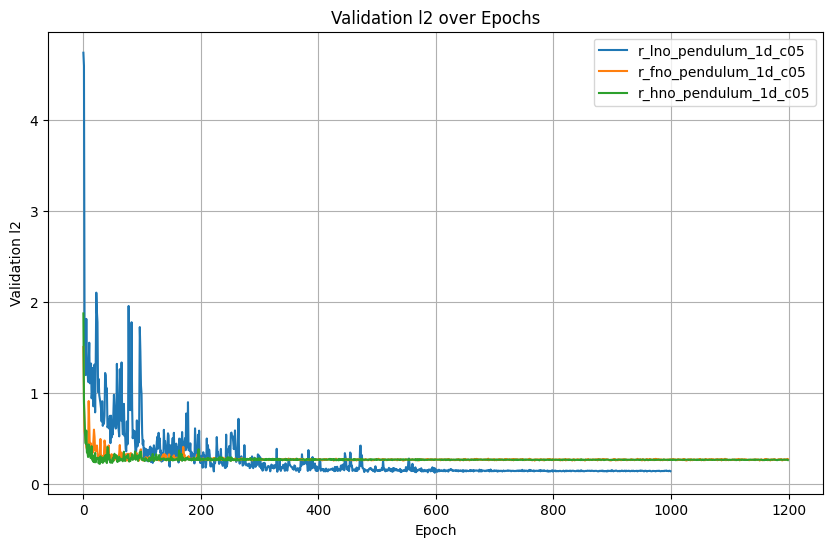

In [7]:
# Plot Train Loss
# plot_metrics(logs_data, metric='Train Loss')

# Plot Validation Loss
# plot_metrics(logs_data, metric='Validation Loss')

# Plot Train l2 if available
# plot_metrics(logs_data, metric='Train MSE')

# Plot Train l2 if available
plot_metrics(logs_data, metric='Train l2')

# Plot Validation l2 if available
plot_metrics(logs_data, metric='Validation l2')

### Compare Multiple Metrics

In [8]:
### Time 
# Compute cumulative time for each log
for df in logs_data.values():
    df['Cumulative Time'] = df['Time'].cumsum()

In [9]:
def plot_loss_vs_time(logs_data, loss_metric='Train Loss'):
    """
    Plots the specified loss metric against cumulative time for each log file.
    """
    plt.figure(figsize=(10, 6))
    metric_found = False
    for filename, df in logs_data.items():
        label = filename.split('/')[1].split('.')[0]
        if loss_metric in df.columns and 'Cumulative Time' in df.columns:
            plt.plot(df['Cumulative Time'], df[loss_metric], label=label)
            metric_found = True
        else:
            print(f"Required data not found in {filename}")
    if metric_found:
        plt.xlabel('Cumulative Time (s)')
        plt.ylabel(loss_metric)
        plt.title(f'{loss_metric} vs. Cumulative Time')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"plots/time_{loss_metric}.png")
        plt.show()
    else:
        print(f"Metric '{loss_metric}' or 'Cumulative Time' not found in any log files.")

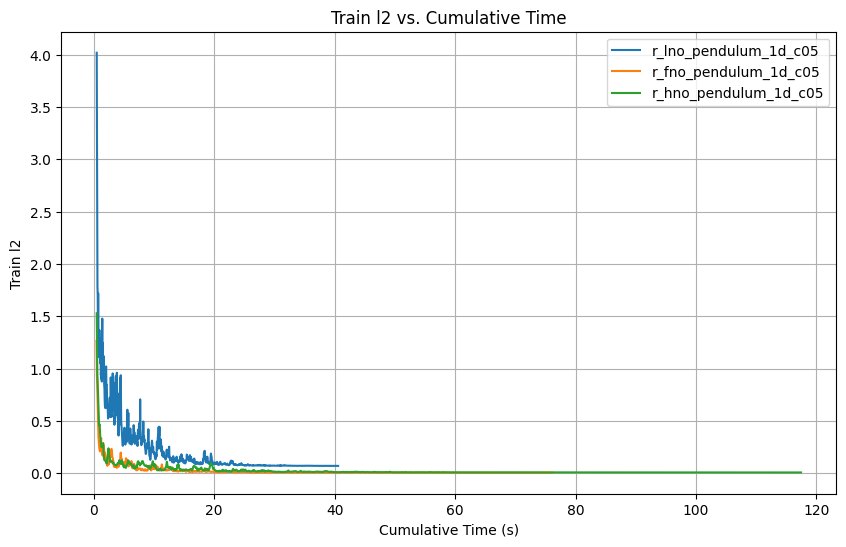

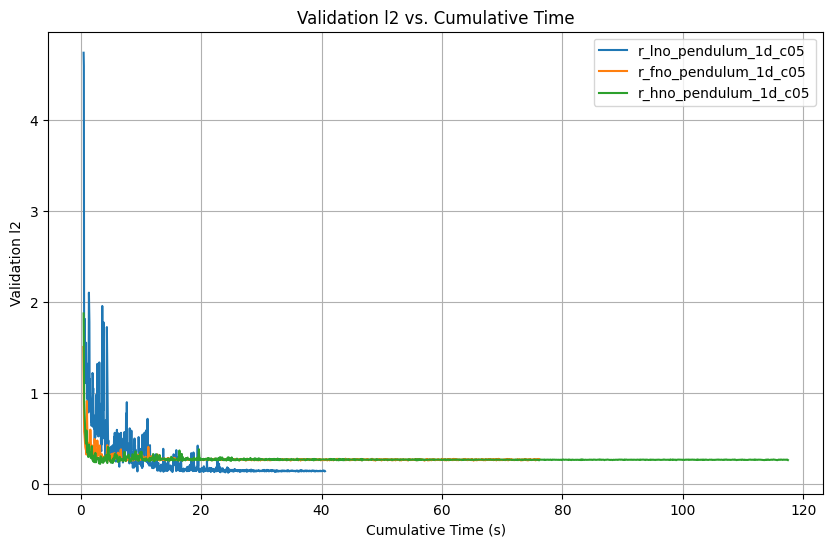

In [10]:
# Plot Train Loss vs. Cumulative Time
plot_loss_vs_time(logs_data, loss_metric='Train l2')

# Plot Validation Loss vs. Cumulative Time
plot_loss_vs_time(logs_data, loss_metric='Validation l2')

###  Analyze each output file individually 

In [11]:
def plot_multiple_metrics(df, metrics, title='Metrics over Epochs'):
    """
    Plots multiple metrics from a single DataFrame.
    """
    plt.figure(figsize=(10, 6))
    for metric in metrics:
        if metric in df.columns:
            plt.plot(df['Epoch'], df[metric], label=metric)
        else:
            print(f"Metric '{metric}' not found in DataFrame.")
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'Metrics for {title}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"plots/{title}.png")
    plt.show()

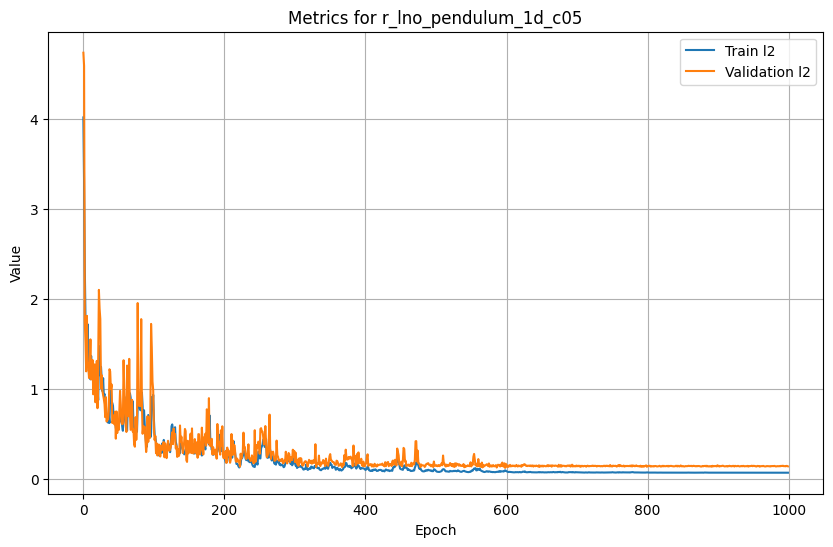

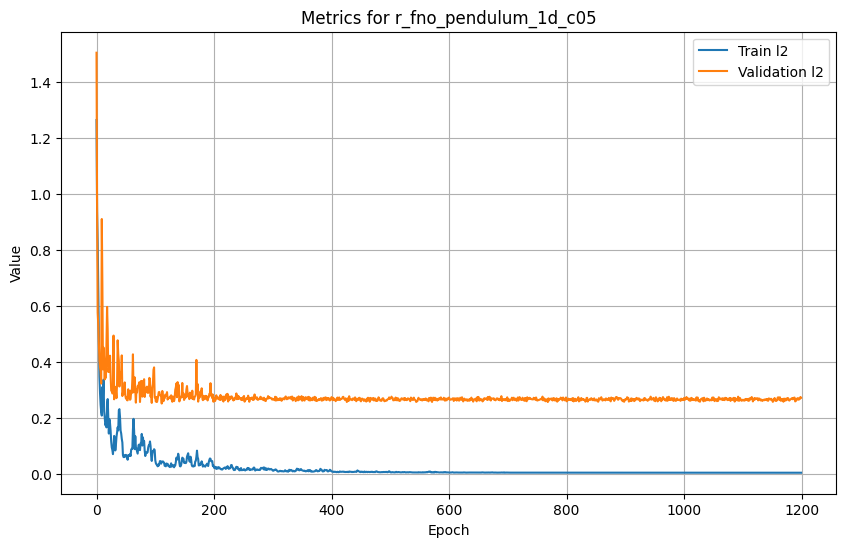

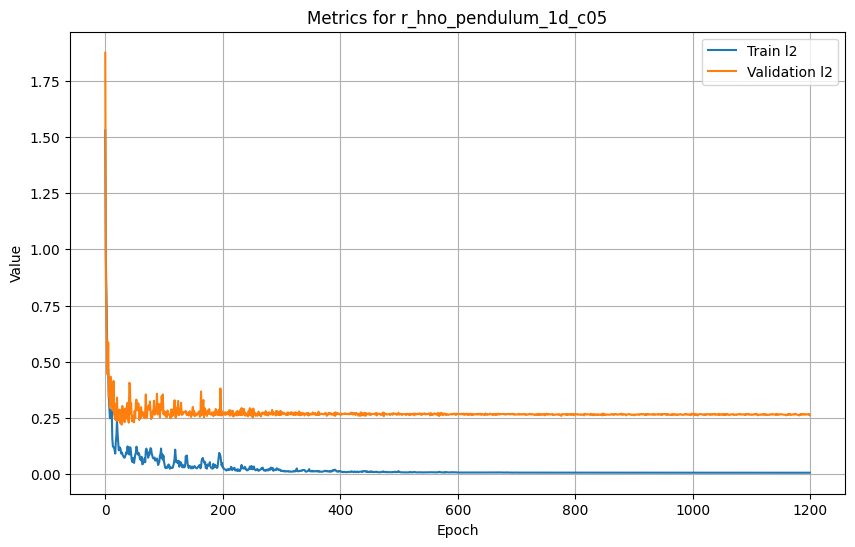

results/r_hno_pendulum_1d_c05.txt not found in logs_data.


In [12]:
# Choose a log file to plot multiple metrics
# filename = 'output_h2d_darcy241.txt'  # Replace with your actual filename

# directory = "results/"

# filename = directory + filename

for idx, filename in enumerate(logs_data):
    df = logs_data[filename]
    title = filename.split('/')[1].split('.')[0]
    metrics = ['Train l2', 'Validation l2']
    plot_multiple_metrics(df, metrics, title=title)
else:
    print(f"{filename} not found in logs_data.")


### Save Processed Data 

In [13]:
# Save DataFrames to CSV files
# for filename, df in logs_data.items():
#     csv_filename = os.path.splitext(filename)[0] + '.csv'
#     df.to_csv(csv_filename, index=False)
#     print(f"Saved {csv_filename}")